## Project: Plant Seedlings

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained model based on the VGG16 model.

Used Dataset from: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset

The model is trained on food images to distinguish plant seeds divided in 12 classes: Black Grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen, Loose Silky Bent, Maize, Scentless Mayweed, Shepherd Purse, Small flowered Cranesbill, and Sugar Beet.

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [1]:
#!pip install tensorflow==2.15.0

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#! cp /content/drive/MyDrive/Dog_Breed_Dataset.zip .

In [4]:
#!unzip Dog_Breed_Dataset.zip

In [5]:
!python3 --version

Python 3.10.12


Check what GPU I've been assigned.

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  6 18:47:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Memory info

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/content/Dog_Breed_Dataset"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16, ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation

### Shuffle images from directory into train, valid, and test sets

In [12]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [13]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True,
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)),
                                               shuffle=True,random_state=rs)

                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [14]:
# Print the count of items from each class

count = 0
for folder in os.listdir(train_dir):
    folder_pics = len(os.listdir(os.path.join(train_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The Italian_greyhound class has 127 pictures.
The Eskimo_dog class has 104 pictures.
The keeshond class has 110 pictures.
The Leonberg class has 146 pictures.
The American_Staffordshire_terrier class has 114 pictures.
The Australian_terrier class has 137 pictures.
The briard class has 106 pictures.
The papillon class has 137 pictures.
The Brabancon_griffon class has 107 pictures.
The redbone class has 103 pictures.
The wire-haired_fox_terrier class has 109 pictures.
The Walker_hound class has 107 pictures.
The miniature_schnauzer class has 107 pictures.
The Doberman class has 104 pictures.
The Greater_Swiss_Mountain_dog class has 117 pictures.
The German_shepherd class has 106 pictures.
The Bouvier_des_Flandres class has 104 pictures.
The clumber class has 104 pictures.
The groenendael class has 104 pictures.
The silky_terrier class has 128 pictures.
The Welsh_springer_spaniel class has 104 pictures.
The Ibizan_hound class has 131 pictures.
The Kerry_blue_terrier class has 125 pictures

## Let us have a look at the classes we are going to classify

In [15]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(train_dir):
    pics = random.choice(os.listdir(os.path.join(train_dir, folder)))
    path_pic = os.path.join(train_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

#print(image_examples_dict)

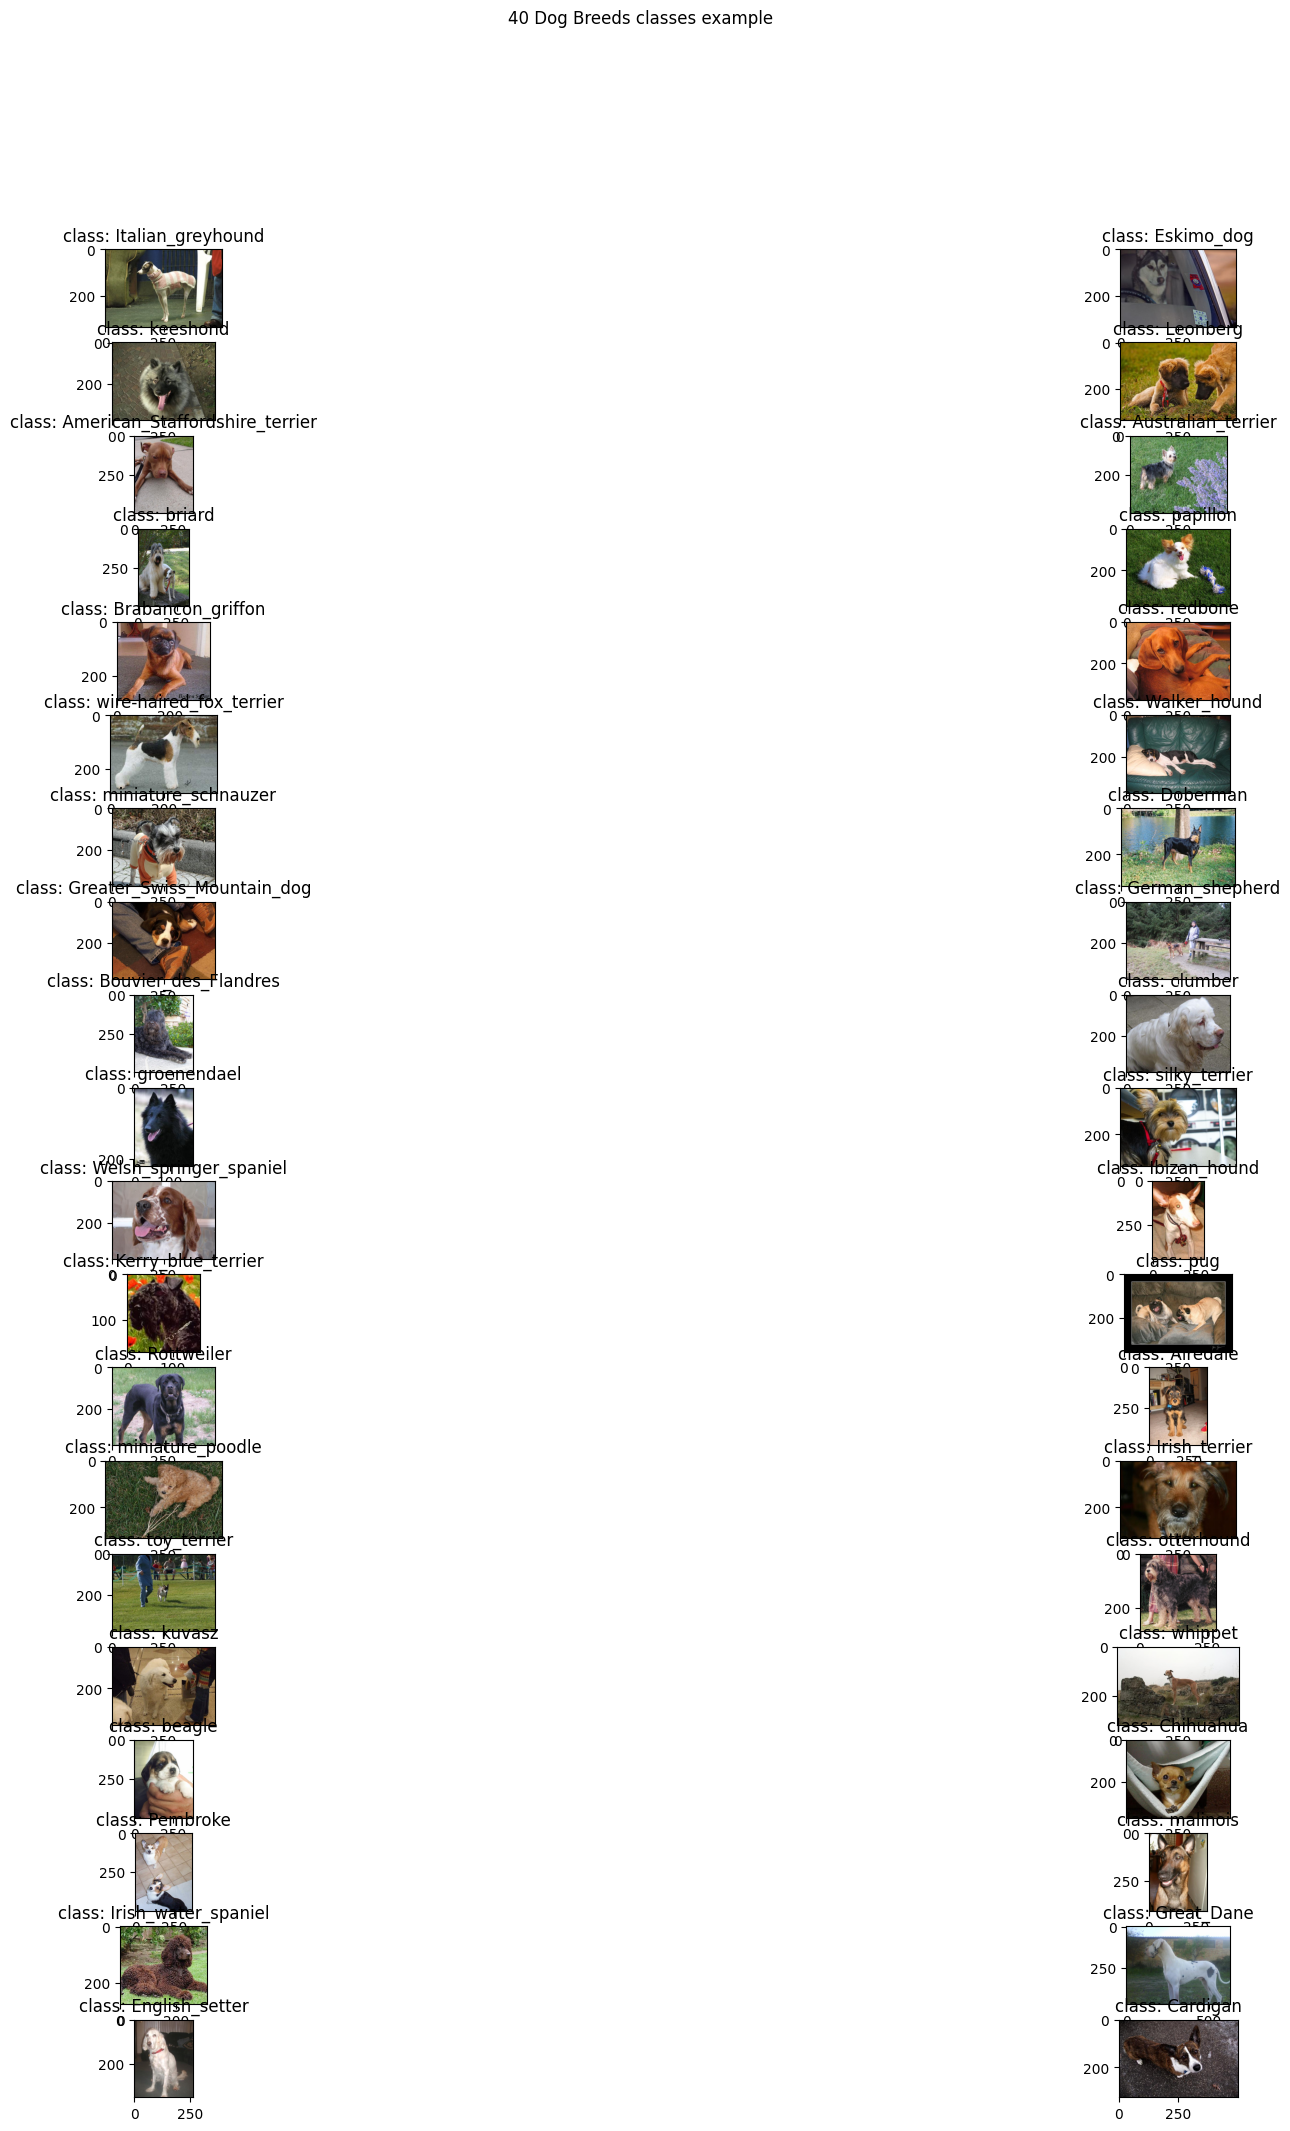

In [16]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(24, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('40 Dog Breeds classes example')
plt.show()

## Model definition


In [17]:
# here I define some important parameter that are going to be used in both models

#num_classes =

image_resize = 224

batch_size_training = 56
batch_size_validation = 56

num_epochs = 8 * 2

Now we can generate train and validation set with ImageDataGenerator

In [18]:
def get_data_generator(preprocessinput):
  # instantiate the image data generator
  data_generator = ImageDataGenerator(preprocessing_function=preprocessinput)

  train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

  validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
    )

  test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
  )
  return train_generator, validation_generator, test_generator

Here we define some optimization parameters that are going to be used with both models.

In [19]:
train_generator_cnn, validation_generator_cnn, test_generator_cnn = get_data_generator(None)

num_classes = train_generator_cnn.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_cnn)
steps_per_epoch_validation = len(validation_generator_cnn)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


## Build the model

### we start with the tailored-made CNN model

In [20]:
#del(model_cnn)

In [21]:
def get_model_cnn():
    #
    input = Input(shape=(image_resize,image_resize,3,)) # (None, 224, 224, 3)

    x = Conv2D(64,(3,3),activation=None,padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),activation=None,padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),activation=None,padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,(3,3),activation=None, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),activation=None, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(512,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(1024,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(1024,(3,3),activation='relu')(x)

    x = GlobalAveragePooling2D()(x)

    flat = Flatten()(x)

    x = Dropout(0.3)(flat)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)

    pred  = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=pred)

    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [22]:
model_cnn = get_model_cnn()

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1728      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36864     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                            

In [23]:
model_cnn.layers

In [24]:
%%time

start_datetime = datetime.now()

with tf.device('/gpu:0'):

  num_epochs = 8 * 3

  fit_cnn = model_cnn.fit(
    train_generator_cnn,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_cnn,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
  )

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/24
257/257 [==============================] - 274s 924ms/step - loss: 4.8014 - accuracy: 0.0129 - val_loss: 4.7408 - val_accuracy: 0.0136
Epoch 2/24
257/257 [==============================] - 235s 913ms/step - loss: 4.7059 - accuracy: 0.0239 - val_loss: 4.6132 - val_accuracy: 0.0242
Epoch 3/24
257/257 [==============================] - 228s 889ms/step - loss: 4.6037 - accuracy: 0.0290 - val_loss: 4.5181 - val_accuracy: 0.0375
Epoch 4/24
257/257 [==============================] - 228s 887ms/step - loss: 4.5321 - accuracy: 0.0329 - val_loss: 4.4327 - val_accuracy: 0.0468
Epoch 5/24
257/257 [==============================] - 228s 888ms/step - loss: 4.4412 - accuracy: 0.0393 - val_loss: 4.3770 - val_accuracy: 0.0520
Epoch 6/24
257/257 [==============================] - 229s 891ms/step - loss: 4.3475 - accuracy: 0.0483 - val_loss: 4.4020 - val_accuracy: 0.0400
Epoch 7/24
257/257 [==============================] - 228s 889ms/step - loss: 4.2416 - accuracy: 0.0582 - val_loss: 4.2156 -

In [25]:
# Evaluate CNN on test_generator

eval_cnn = model_cnn.evaluate(test_generator_cnn)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

3145/3145 [==============================] - 30s 9ms/step - loss: 3.3090 - accuracy: 0.1959
CNN Test loss:  3.3089852333068848
CNN Test Accuracy:  0.1958664506673813


In [26]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "."
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")

save_model(model_cnn, "classifier_cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model updated


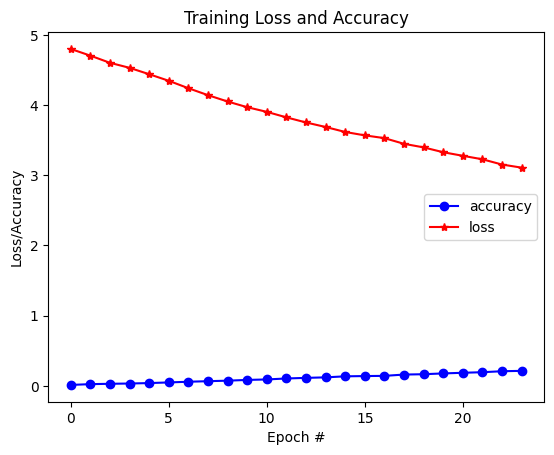

In [27]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# ResNet50

### Instantiate the generator for resnet50

In [29]:
train_generator_r, validation_generator_r, test_generator_r = get_data_generator(preprocess_input_resnet)

num_classes = train_generator_r.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_r)
steps_per_epoch_validation = len(validation_generator_r)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [30]:
def get_model_resnet():

    base_model = ResNet50(weights='imagenet', include_top=False) #imports the ResNet50 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = GlobalAveragePooling2D()(x) # (None, 512)

    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(1024,activation='relu')(x) # (None, 1024)
    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(512,activation='relu')(x) # (None, 512)

    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [31]:
model_resnet = get_model_resnet()

model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [32]:
model_resnet.layers

In [35]:
%%time

start_datetime = datetime.now()

fit_resnet = model_resnet.fit(
    train_generator_r,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_r,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/16
257/257 [==============================] - 86s 335ms/step - loss: 1.6155 - accuracy: 0.5541 - val_loss: 1.0312 - val_accuracy: 0.6810
Epoch 2/16
257/257 [==============================] - 76s 294ms/step - loss: 1.0287 - accuracy: 0.6881 - val_loss: 0.9654 - val_accuracy: 0.7078
Epoch 3/16
257/257 [==============================] - 76s 294ms/step - loss: 0.8671 - accuracy: 0.7311 - val_loss: 0.9397 - val_accuracy: 0.7152
Epoch 4/16
257/257 [==============================] - 72s 282ms/step - loss: 0.7721 - accuracy: 0.7524 - val_loss: 0.8851 - val_accuracy: 0.7323
Epoch 5/16
257/257 [==============================] - 74s 288ms/step - loss: 0.6748 - accuracy: 0.7832 - val_loss: 0.9423 - val_accuracy: 0.7239
Epoch 6/16
257/257 [==============================] - 75s 292ms/step - loss: 0.6188 - accuracy: 0.7989 - val_loss: 0.8998 - val_accuracy: 0.7375
Epoch 7/16
257/257 [==============================] - 82s 320ms/step - loss: 0.5673 - accuracy: 0.8154 - val_loss: 0.9076 - val_ac

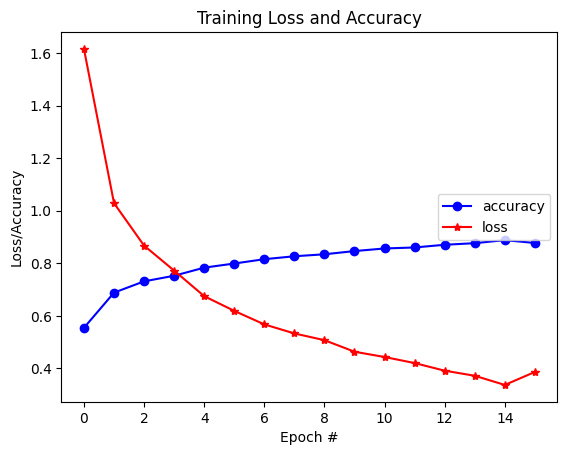

In [36]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_resnet.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_resnet.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [37]:
eval_resnet = model_resnet.evaluate(test_generator_r)
print('ResNet Test loss: ', eval_resnet[0])
print('ResNet Test Accuracy: ', eval_resnet[1])

3145/3145 [==============================] - 39s 12ms/step - loss: 0.9488 - accuracy: 0.7663
ResNet Test loss:  0.9488261938095093
ResNet Test Accuracy:  0.7662957310676575


In [ ]:
# Save the model to a file
save_model(model_resnet, "classifier_resnet_model.h5")

# VGG16

### Instantiate the data generator with the VGG16 preprocessing

In [38]:
train_generator_v, validation_generator_v, test_generator_v = get_data_generator(preprocess_input_resnet)

num_classes = train_generator_v.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_v)
steps_per_epoch_validation = len(validation_generator_v)

print(steps_per_epoch_training,steps_per_epoch_validation)


Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [39]:
def get_model_vgg():

    base_model = VGG16(weights='imagenet', include_top=False) #imports the VGG16 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = GlobalAveragePooling2D()(x) # (None, 512)

    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(1024,activation='relu')(x) # (None, 1024)
    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(512,activation='relu')(x) # (None, 512)

    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [40]:
model_vgg = get_model_vgg()

model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [41]:
model_vgg.layers

In [42]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator_v,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_v,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/16
257/257 [==============================] - 105s 358ms/step - loss: 3.3605 - accuracy: 0.2601 - val_loss: 1.6374 - val_accuracy: 0.5402
Epoch 2/16
257/257 [==============================] - 86s 335ms/step - loss: 1.9010 - accuracy: 0.4766 - val_loss: 1.4189 - val_accuracy: 0.5806
Epoch 3/16
257/257 [==============================] - 85s 332ms/step - loss: 1.6777 - accuracy: 0.5257 - val_loss: 1.3471 - val_accuracy: 0.6235
Epoch 4/16
257/257 [==============================] - 86s 333ms/step - loss: 1.5059 - accuracy: 0.5660 - val_loss: 1.2675 - val_accuracy: 0.6309
Epoch 5/16
257/257 [==============================] - 86s 333ms/step - loss: 1.4035 - accuracy: 0.5846 - val_loss: 1.2020 - val_accuracy: 0.6519
Epoch 6/16
257/257 [==============================] - 86s 333ms/step - loss: 1.3510 - accuracy: 0.6022 - val_loss: 1.1815 - val_accuracy: 0.6684
Epoch 7/16
257/257 [==============================] - 85s 332ms/step - loss: 1.2981 - accuracy: 0.6205 - val_loss: 1.2174 - val_a

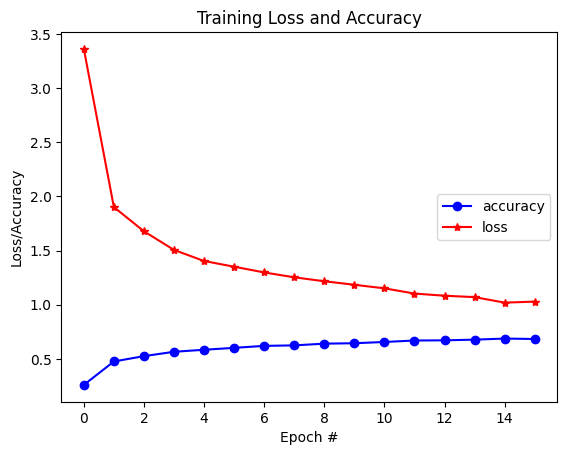

In [43]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [44]:
eval_vgg = model_vgg.evaluate(test_generator_v)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 33s 10ms/step - loss: 1.1333 - accuracy: 0.6811
VGG Test loss:  1.133274793624878
VGG Test Accuracy:  0.6810810565948486


In [ ]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg_model.h5")

#  Persist the models and evaluate on the test set

In [ ]:
# load the models

#model_cnn = load_model('../saved_models/classifier_cnn_model.h5')

#model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

## Plot the Confusion Matrix

### We see that the VGG16 pre-trained model performs better than our defined CNN model.